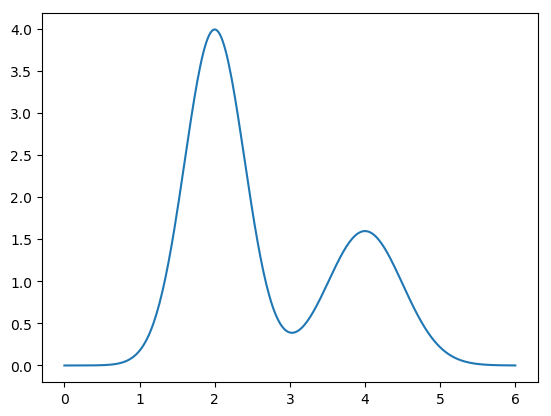

In [1]:
using PyCall
include("../src/gauss_error.jl")
include("../src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

# function phi(x::Float64)
#     return cos(x)
# end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))
savefig("function.png", dpi=1000)

In [2]:
function kernel(x::Float64, y::Float64)
    return getOpticsKernels("gaussian")(x, y)
end

kernel (generic function with 1 method)

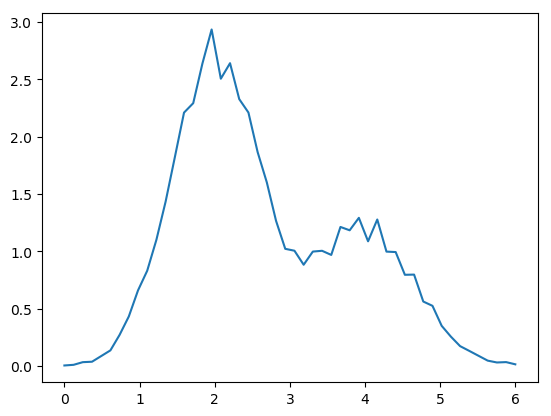

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = collect(range(a, stop = b, length=50))
ftrue = convolution.(y)
sig = 0.05*abs.(ftrue) +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
# f = [0.0250447, 0.0259323, 0.0300055, 0.0697762, 0.106568, 0.199481, 0.286887, 0.448353, 0.564742, 0.793431, 1.18831, 1.41718, 1.73265, 2.2737, 2.37566, 2.64492, 2.82908, 2.52841, 2.51898, 2.64624, 2.22185, 1.75508, 1.48881, 1.2669, 1.09605, 0.953436, 0.859025, 0.994736, 0.938362, 1.04007, 1.11036, 1.17168, 1.2502, 1.15296, 1.20842, 1.05919, 1.0105, 0.859411, 0.714523, 0.612392, 0.508907, 0.396421, 0.264456, 0.205983, 0.125906, 0.0530743, 0.0718868, 0.0308666, 0.0121104, 0.0207568]
plot(y, f)
savefig("integrated_function.png", dpi=1000)

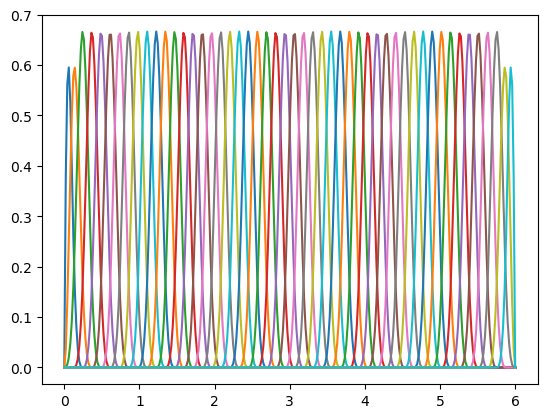

┌ Info: Created Cubic spline basis.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:213


In [4]:
basis = CubicSplineBasis(y, "dirichlet")
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end
savefig("basis.png", dpi=1000)

In [5]:
# @time discretize_kernel(basis, kernel, y)

Kmn = discretize_kernel(basis, kernel, y)

┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:48
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:59


50×50 Array{Float64,2}:
 0.0564223    0.0806035    0.0965189    …  2.92235e-42  8.08106e-44
 0.0568853    0.0853341    0.108971        1.38854e-40  4.15223e-42
 0.0528153    0.0832629    0.113468        6.07839e-39  1.96507e-40
 0.0451581    0.0748768    0.108971        2.45149e-37  8.56574e-39
 0.0355576    0.0620605    0.0965189       9.10946e-36  3.43908e-37
 0.0257843    0.0474092    0.0788467    …  3.11879e-34  1.27179e-35
 0.017219     0.0333805    0.0594047       9.83828e-33  4.33195e-34
 0.0105901    0.0216627    0.0412783       2.85958e-31  1.3591e-32 
 0.0059983    0.0129576    0.0264535       7.65849e-30  3.92757e-31
 0.00312899   0.00714389   0.0156352       1.88996e-28  1.04544e-29
 0.00150324   0.00363032   0.0085227    …  4.29773e-27  2.5632e-28 
 0.000665135  0.00170043   0.0042845       9.00557e-26  5.78859e-27
 0.00027105   0.000734141  0.0019864       1.73891e-24  1.20413e-25
 ⋮                                      ⋱                          
 5.78859e-27  9.00557e-2

In [6]:
model = GaussErrorMatrixUnfolder(omega(basis, 2))

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:225
┌ Info: Omega caclulated successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:242
┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:86


GaussErrorMatrixUnfolder(Array{Float64,2}[[13072.1 -3676.53 … 0.0 0.0; -3676.53 2451.02 … 0.0 0.0; … ; 0.0 0.0 … 2451.02 -3676.53; 0.0 0.0 … -3676.53 13072.1]], 50, "EmpiricalBayes", nothing)

In [7]:
# @time solve(model, Kmn, f, sig)

result = solve(model, Kmn, f, sig)

┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:117
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:145
┌ Info: Starting solve_correct...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:156
┌ Info: Starting optimal_alpha...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:164
┌ Info: Starting optimization...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:185


Iter     Function value   Gradient norm 
     0    -7.677636e+02     2.448560e+01
     1    -7.899800e+02     8.324964e+00
     2    -8.018990e+02     1.115813e+00
     3    -8.020156e+02     2.669638e-02
     4    -8.020157e+02     8.066738e-07
     5    -8.020157e+02     1.267189e-07
     6    -8.020157e+02     9.890254e-08
     7    -8.020157e+02     3.090704e-08
     8    -8.020157e+02     1.421724e-07
     9    -8.020157e+02     2.565285e-07


┌ Info: Optimized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:201
┌ Info: Ending solve_correct...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:212


Dict{String,Array{Float64,N} where N} with 3 entries:
  "errors" => [0.00404243 0.00791843 … -2.14928e-6 -7.10428e-7; 0.00791843 0.02…
  "alphas" => [0.0479681]
  "coeff"  => [0.00166905, 0.00445215, -0.0130103, -0.0527567, -0.0988871, -0.1…

In [8]:
phivec = PhiVec(result, basis)

PhiVec([0.00166905, 0.00445215, -0.0130103, -0.0527567, -0.0988871, -0.12407, -0.0962713, 0.013944, 0.226692, 0.547709  …  0.342006, 0.197514, 0.0953851, 0.0336284, 0.00507085, -0.000911858, 0.00388598, 0.00905694, 0.00804015, 0.00274876], CubicSplineBasis(0.0, 6.0, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.734694  …  5.26531, 5.38776, 5.5102, 5.63265, 5.7551, 5.87755, 6.0, 6.0, 6.0, 6.0], BaseFunction[BaseFunction(BSpline(1, 3, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.734694  …  5.26531, 5.38776, 5.5102, 5.63265, 5.7551, 5.87755, 6.0, 6.0, 6.0, 6.0], ##39#41{Int64,Int64,Array{Float64,1}}(1, 3, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.734694  …  5.26531, 5.38776, 5.5102, 5.63265, 5.7551, 5.87755, 6.0, 6.0, 6.0, 6.0], Box(#b_spline_function#40(Box(#= circular reference @-2 =#))))), (0.0, 6.0)), BaseFunction(BSpline(2, 3, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.

┌ Info: PhiVec called successfully
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:105
┌ Info: PhiVec called successfully
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:145


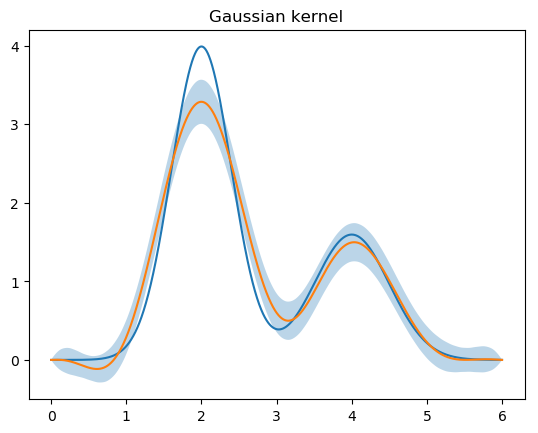

┌ Info: PhiVec called successfully
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:105


PyObject Text(0.5, 1.0, 'Gaussian kernel')

In [9]:
x = collect(range(a, stop=b, length=5000))
plot(x, phi.(x))

phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, call(phivec, x))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)
title("Gaussian kernel")
# savefig("result.png", dpi=1000)

In [10]:
print(f)

[0.00435421, 0.0101302, 0.0332869, 0.0370517, 0.0864364, 0.136026, 0.271438, 0.431699, 0.658999, 0.830571, 1.10079, 1.43325, 1.81957, 2.2093, 2.2915, 2.63749, 2.93414, 2.50479, 2.64021, 2.32685, 2.20985, 1.86473, 1.60012, 1.26578, 1.02156, 1.005, 0.882789, 0.99758, 1.00438, 0.96831, 1.21222, 1.1831, 1.29173, 1.08712, 1.27714, 0.997188, 0.993418, 0.795121, 0.796767, 0.561877, 0.524446, 0.349989, 0.255793, 0.173072, 0.131435, 0.0889845, 0.0466162, 0.0305069, 0.0337661, 0.0144448]

In [11]:
print(result["errors"])

[0.00404243 0.00791843 0.0068399 0.00301205 -0.000922454 -0.00359711 -0.00461061 -0.00418412 -0.00284404 -0.00117256 0.000353778 0.00143916 0.0019749 0.00200204 0.00165466 0.00110304 0.000508336 -6.18596e-6 -0.000367502 -0.000551983 -0.000575678 -0.000480187 -0.000317876 -0.000139198 1.62537e-5 0.000124313 0.000176739 0.000178544 0.000143466 8.88937e-5 3.14049e-5 -1.63687e-5 -4.72512e-5 -5.95269e-5 -5.58288e-5 -4.14304e-5 -2.24395e-5 -4.28708e-6 9.25833e-6 1.64768e-5 1.75486e-5 1.40254e-5 8.12001e-6 2.01066e-6 -2.6845e-6 -5.17252e-6 -5.47521e-6 -4.19465e-6 -2.14928e-6 -7.10428e-7; 0.00791843 0.0258598 0.020207 0.00941887 -0.00259436 -0.0106369 -0.0137708 -0.0125619 -0.00859624 -0.00360889 0.000967683 0.00424027 0.00587436 0.00598501 0.00496818 0.00333094 0.00155555 1.26805e-5 -0.00107649 -0.00163845 -0.00171882 -0.00144044 -0.000959213 -0.000426083 3.99331e-5 0.000365679 0.000525574 0.000533839 0.000431036 0.000268953 9.72071e-5 -4.62028e-5 -0.000139507 -0.000177264 -0.000167102 -0.000

00566917 0.00018662 -0.000130945 -0.000276222 -0.000214598 -7.23088e-5; -0.000367502 -0.00107649 -0.000886431 0.000804896 0.00342851 0.00585078 0.00673974 0.00499239 0.000143074 -0.00733538 -0.0159176 -0.0231555 -0.0260683 -0.0217918 -0.00838553 0.0140906 0.0430188 0.0706839 0.0895495 0.069224 0.0403163 0.0105197 -0.0123889 -0.0258204 -0.0297942 -0.0263266 -0.018315 -0.00872725 7.43398e-6 0.00632439 0.00959362 0.00998731 0.00822445 0.00527487 0.00209175 -0.000581825 -0.00231299 -0.00298996 -0.00276363 -0.00194844 -0.000911837 2.25491e-5 0.000640994 0.000867241 0.000752719 0.000437718 9.60745e-5 -0.00012306 -0.000144743 -4.9381e-5; -0.000551983 -0.00163845 -0.00211923 -0.00102708 0.00139092 0.00432383 0.00661075 0.00704515 0.00472517 -0.000614476 -0.00836237 -0.0169501 -0.0239836 -0.0266065 -0.0221035 -0.0086575 0.0136125 0.0421121 0.069224 0.0875544 0.0668563 0.0378437 0.00824718 -0.0141945 -0.0269913 -0.0302924 -0.0262392 -0.0178194 -0.00804032 0.000681518 0.00683352 0.00985829 0.0100

-2.24395e-5 -6.81032e-5 -0.000140735 -0.000196645 -0.000203816 -0.000133574 2.47952e-5 0.000253174 0.000500921 0.000690534 0.000732777 0.000549219 9.81106e-5 -0.000601859 -0.00145601 -0.00229217 -0.0028778 -0.00295801 -0.00231299 -0.000828326 0.0014342 0.00418345 0.00688527 0.008809 0.00914759 0.00720913 0.0026565 -0.00425195 -0.0124875 -0.0202188 -0.0249896 -0.0241675 -0.0156225 0.00121177 0.024676 0.0481431 0.0650432 0.0455916 0.0204799 -0.00309175 -0.0183352 -0.0239538 -0.0213018 -0.0135029 -0.00411828 0.00377929 0.00821397 0.00852903 0.00529326 0.00176685; -4.28708e-6 -1.37703e-5 -5.45662e-5 -0.000116096 -0.000170898 -0.000182241 -0.000118764 3.16398e-5 0.000252034 0.000493626 0.000681557 0.000729271 0.000559639 0.000129327 -0.00054834 -0.00138757 -0.00222699 -0.00284408 -0.00298996 -0.00244396 -0.00108225 0.00105145 0.00369087 0.00632995 0.00826432 0.00870522 0.0069644 0.00268772 -0.00390805 -0.0118594 -0.0194164 -0.0242054 -0.0236557 -0.0156562 0.000402396 0.0229716 0.0455916 0.0

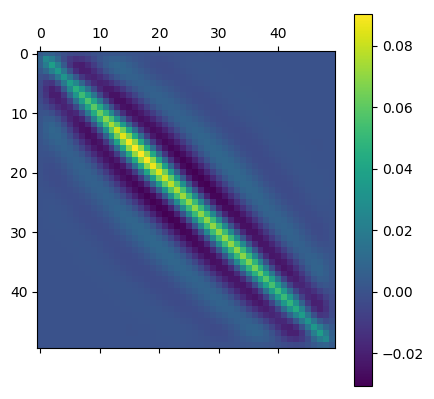

PyObject <matplotlib.colorbar.Colorbar object at 0x1abe11978>

In [12]:
matshow(result["errors"])
colorbar()